In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import visdom

In [3]:
vis = visdom.Visdom()

Setting up a new session...


In [4]:
from preprocessing_utils import process_sat_data, pickle_save, pickle_load
from trajectory import trajectory

In [5]:
data_train = pd.read_csv('../data/train.csv')
data_test = pd.read_csv('../data/track1/test.csv')

In [6]:
train_data = data_train.copy(deep=True)
test_data = data_test.copy(deep=True)

In [7]:
process_sat_data(train_data, test_data, scale=10000)

# Rodrigues Rotation

$ {\displaystyle \mathbf {v} _{\mathrm {rot} }=\mathbf {v} \cos \theta +(\mathbf {k} \times \mathbf {v} )\sin \theta +\mathbf {k} ~(\mathbf {k} \cdot \mathbf {v} )(1-\cos \theta )\,} $

In [8]:
sat_id = 481
ellipse_id = 1
ellipse_data = train_data[train_data['sat_id'] == sat_id].loc[:, ['x_sim', 'y_sim', 'z_sim', 'epoch']]
ellipse_data = ellipse_data.iloc[ellipse_id * 24 : (ellipse_id + 1) * 24, :]
time = ellipse_data['epoch'].values
ellipse_data = ellipse_data.iloc[:, [0,1,2]].values
ellipse_mean = ellipse_data.mean(axis=0)
ellipse_data -= ellipse_mean

In [9]:
ellipse_normal = np.cross(ellipse_data[0]-ellipse_data[1], ellipse_data[0]-ellipse_data[2])
ellipse_normal /= np.linalg.norm(ellipse_normal)
if (ellipse_normal[2] < 0):
    ellipse_normal *= -1

In [10]:
ellipse_normal

array([  1.89291810e-03,  -6.11574389e-04,   9.99998021e-01])

In [11]:
z_axis = np.array([0,0,1])

In [12]:
theta = np.arccos(np.dot(ellipse_normal, z_axis))

In [13]:
theta / np.pi * 180

0.1139763758306853

In [14]:
rotation_axis = np.cross(ellipse_normal, z_axis)
rotation_axis /= np.linalg.norm(rotation_axis)

In [15]:
rotation_axis

array([-0.30743787, -0.95156816,  0.        ])

In [16]:
def rodrigues_rotate(vect, axis, theta):
    rotated = vect * np.cos(theta)
    rotated += np.cross(axis, vect) * np.sin(theta)
    rotated += axis * np.dot(z_axis, vect) * (1 - np.cos(theta))
    return rotated

In [17]:
rotated = rodrigues_rotate(ellipse_normal, rotation_axis, theta)

In [18]:
np.linalg.norm(rotated)

1.0000000000019573

In [19]:
rotated

array([ -6.08290179e-07,  -1.88275289e-06,   1.00000000e+00])

In [20]:
transformed_data = np.array([rodrigues_rotate(vect, rotation_axis, theta) for vect in ellipse_data])

In [21]:
np.abs(transformed_data).mean(axis=0)

array([  4.50406270e+00,   4.62090575e+00,   9.09804669e-04])

In [22]:
def plot_rotation(ellipse_normal, rotation_axis, rotated, transformed_data, ellipse_data):
    normal_line = np.array([i * ellipse_normal for i in range(10)])
    axis_line = np.array([i * rotation_axis for i in range(10)])
    rotated_line = np.array([i * rotated for i in range(10)])
    labels = [1] * (len(ellipse_data)+len(normal_line)) + [2] * (len(transformed_data)+len(rotated_line)) + [3] * len(axis_line)
    concat = np.concatenate([ellipse_data, normal_line, transformed_data, rotated_line, axis_line], axis=0)
    vis.scatter(concat, labels, opts={'markersize': 3}, win='rotation')

In [23]:
plot_rotation(ellipse_normal, rotation_axis, rotated, transformed_data, ellipse_data)

In [24]:
transformed_data = transformed_data[:,[0,1]]

# 2D Ellipse Fitting

In [25]:
class Ellipse(nn.Module):
    def __init__(self, name, major, minor, cx, cy, theta):
        super(Ellipse, self).__init__()
        self.name = name
        self.a = nn.Parameter(1/(major**2))
        self.b = nn.Parameter(1/(minor**2))
        self.cx = nn.Parameter(cx)
        self.cy = nn.Parameter(cy)
        self.theta = nn.Parameter(theta)
    def forward(self, data):
        x_rot = data[:,0] - self.cx
        y_rot = data[:,1] - self.cy
        x = x_rot * torch.cos(self.theta) - y_rot * torch.sin(self.theta)
        y = x_rot * torch.sin(self.theta) + y_rot * torch.cos(self.theta)
        res = (self.a * x**2 + self.b * y**2 - 1) ** 2
        return [res, x, y]
    def plot(self, data):
        major = np.sqrt(1 / self.a.detach().numpy())
        minor = np.sqrt(1 / self.b.detach().numpy())
        theta = -self.theta.detach().numpy()
        cx = self.cx.detach().numpy()
        cy = self.cy.detach().numpy()
        print('Major: {} | Minor: {} | Center: ({},{}) | Rotation: {}'.format(major, minor, cx, cy, theta*180/np.pi))
        generated = []
        for x in np.arange(-major, major, 0.01):
            y = np.sqrt((1 - x**2 / major**2) * minor**2)
            generated.append([x,y])
            generated.append([x,-y])
        generated = np.array(generated)
        generated_transformed = np.transpose(np.array([generated[:,0] * np.cos(theta) - generated[:,1] * np.sin(theta),
                                                       generated[:,0] * np.sin(theta) + generated[:,1] * np.cos(theta)]))
        generated_transformed += [cx, cy]
        plt.scatter(data[:,0], data[:,1])
        plt.scatter(generated_transformed[:,0], generated_transformed[:,1], c='green', s=0.5)

In [26]:
def get_initial_values(data):
    euclidian = []
    pairs = []
    for i in range(23):
        for j in range(i + 1, 24):
            euclidian_distance = np.linalg.norm(data[i] - data[j])
            pairs.append([i, j])
            euclidian.append(euclidian_distance)
    max_index = np.argmax(euclidian) #Index of Longest Chord
    major_axis = data[pairs[max_index][0]] - data[pairs[max_index][1]]
    if (major_axis[1] < 0):
        major_axis *= -1
    major = np.linalg.norm(major_axis) / 2
    center = (data[pairs[max_index][0]] + data[pairs[max_index][1]]) * 0.5
    theta = np.arccos(np.dot(major_axis, [1,0]) / (2 * major))
    return [major, major, center[0], center[1], -theta]

In [27]:
major, minor, cx, cy, theta = [torch.tensor(val).float() for val in get_initial_values(transformed_data)]

In [28]:
major, minor, cx, cy, theta

(tensor(8.2729),
 tensor(8.2729),
 tensor(-0.7743),
 tensor(-2.1286),
 tensor(-1.1253))

In [29]:
model = Ellipse('E', major, major, cx, cy, theta)

In [30]:
optim = torch.optim.Adam(model.parameters(), 0.001)

In [31]:
data = torch.from_numpy(transformed_data).float()

In [32]:
for itr in range(2000):
    optim.zero_grad()
    pred, _, _ = model(data)
    loss = torch.sum(pred)
    loss.backward()
    optim.step()
    if (itr%500 == 0):
        print(loss.item())

0.8510955572128296
0.004964195657521486
2.4294105969602242e-05
2.1202500022354798e-07


Major: 8.308999654358397 | Minor: 6.95976465761189 | Center: (-1.1899152994155884,-1.951551914215088) | Rotation: 58.45036835075962


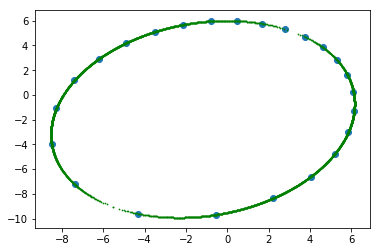

In [33]:
model.plot(transformed_data)